In [1]:
import re, pandas as pd, numpy as np

def load_expectations(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, dtype="string", encoding="utf-8-sig")
    df = df.rename(columns={
        "Business's or organization's expectation of the impact of artificial intelligence on total employment": "Survey_Question"
    })
    df = df[["GEO","Business characteristics","Survey_Question","VALUE","STATUS"]].copy()

    # Canada only, drop unreliable
    df = df[(df["GEO"] == "Canada") & (df["STATUS"] != "F")].copy()

    # Keep NAICS industries: bracket-coded like "Manufacturing [31-33]" OR the (NAICS) all-industry row
    bc = df["Business characteristics"].fillna("")
    naics_mask = bc.str.contains(r"\[", regex=True) | bc.str.contains("NAICS", case=False, regex=False)
    df = df[naics_mask].copy()

    # Numeric values
    df["VALUE"] = pd.to_numeric(df["VALUE"], errors="coerce")

    # Normalize question label to last token after comma: increase / decrease / no change / unknown
    df["question"] = df["Survey_Question"].str.split(",").str[-1].str.strip().str.lower()
    return df

# Load the SAME tables Jo used (adjust paths if your folder differs)
exp25 = load_expectations("../../data/Org-Expectations-Survey-2025/33101047.csv")
exp24 = load_expectations("../../data/Org-Expectations-Survey-2024/33100880.csv")

def pivot_overall(df: pd.DataFrame) -> pd.DataFrame:
    pv = df.pivot_table(index="Business characteristics", columns="question", values="VALUE", aggfunc="first")
    # ensure all four columns exist
    for k in ["increase","decrease","no change","unknown"]:
        if k not in pv.columns: pv[k] = np.nan
    pv = pv[["increase","decrease","no change","unknown"]]

    # Jo's weights
    pv["Overall_Thoughts"] = (pv["increase"]*1.0) + (pv["decrease"]*0.0) + (pv["no change"]*0.7) + (pv["unknown"]*0.5)
    return pv

p25 = pivot_overall(exp25)
p24 = pivot_overall(exp24)

# Merge 2025 vs 2024 and compute Difference
ai_exp_naic = (
    p25[["Overall_Thoughts"]]
    .merge(p24[["Overall_Thoughts"]], left_index=True, right_index=True, suffixes=("_2025","_2024"))
)
ai_exp_naic["Difference"] = ai_exp_naic["Overall_Thoughts_2025"] - ai_exp_naic["Overall_Thoughts_2024"]

# Quick peek + save for sharing with Jo
display(ai_exp_naic.sort_values("Difference", ascending=False).head(10))
display(ai_exp_naic.sort_values("Difference", ascending=True).head(10))
ai_exp_naic.to_csv("ai_expectations_2025_vs_2024_by_industry.csv")
print("Saved: ai_expectations_2025_vs_2024_by_industry.csv")



question,Overall_Thoughts_2025,Overall_Thoughts_2024,Difference
Business characteristics,,,
"Administrative and support, waste management and remediation services [56]",69.37,60.26,9.11
"Mining, quarrying, and oil and gas extraction [21]",67.83,66.72,1.11
Construction [23],67.59,67.24,0.35
"Professional, scientific and technical services [54]",62.18,65.05,-2.87
"North American Industry Classification System (NAICS), all industries",61.53,64.69,-3.16
Health care and social assistance [62],65.35,68.88,-3.53
"Arts, entertainment and recreation [71]",61.89,66.41,-4.52
Manufacturing [31-33],64.87,69.62,-4.75
Finance and insurance [52],60.1,65.32,-5.22


question,Overall_Thoughts_2025,Overall_Thoughts_2024,Difference
Business characteristics,,,
Real estate and rental and leasing [53],44.05,64.26,-20.21
Information and cultural industries [51],62.48,71.54,-9.06
Finance and insurance [52],60.1,65.32,-5.22
Manufacturing [31-33],64.87,69.62,-4.75
"Arts, entertainment and recreation [71]",61.89,66.41,-4.52
Health care and social assistance [62],65.35,68.88,-3.53
"North American Industry Classification System (NAICS), all industries",61.53,64.69,-3.16
"Professional, scientific and technical services [54]",62.18,65.05,-2.87
Construction [23],67.59,67.24,0.35


Saved: ai_expectations_2025_vs_2024_by_industry.csv


Saved: figures\exp_top_gainers_diff.png


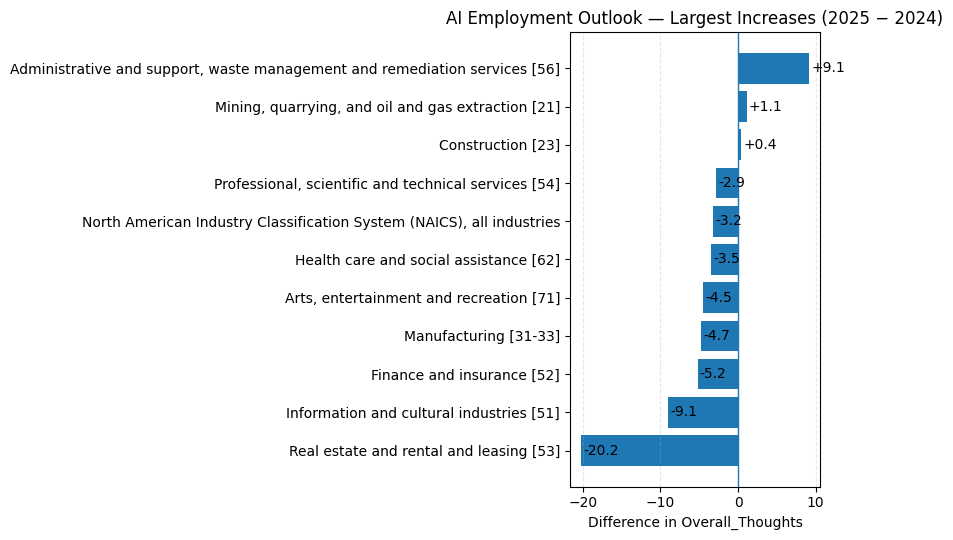

In [5]:
# --- Clean numbers + replot Diff charts safely ---
import os, numpy as np, matplotlib.pyplot as plt

os.makedirs("figures", exist_ok=True)
def savefig(name):
    plt.tight_layout()
    plt.savefig(os.path.join("figures", name), dpi=200, bbox_inches="tight")
    print("Saved:", os.path.join("figures", name))

dfp = ai_exp_naic.copy()
for col in ["Overall_Thoughts_2025","Overall_Thoughts_2024","Difference"]:
    dfp[col] = pd.to_numeric(dfp[col], errors="coerce")

# rows missing either year → can’t compute a diff → drop
dfp = dfp.dropna(subset=["Overall_Thoughts_2025","Overall_Thoughts_2024","Difference"])

# === Biggest improvements (2025 − 2024) ===
topN = 12
pos = dfp.nlargest(topN, "Difference")

fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.barh(range(len(pos)), pos["Difference"].to_numpy(dtype=float))
ax.set_yticks(range(len(pos)), labels=pos.index.astype(str))
ax.invert_yaxis()
ax.set_title("AI Employment Outlook — Largest Increases (2025 − 2024)")
ax.set_xlabel("Difference in Overall_Thoughts")
for i, v in enumerate(pos["Difference"].to_numpy(dtype=float)):
    ax.text(v + 0.3, i, f"{v:+.1f}", va="center")
plt.axvline(0, linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.3)
savefig("exp_top_gainers_diff.png")
plt.show()

# === Biggest declines (2025 −


Saved: figures/exp_2025_stacked_mix_top_industries.png


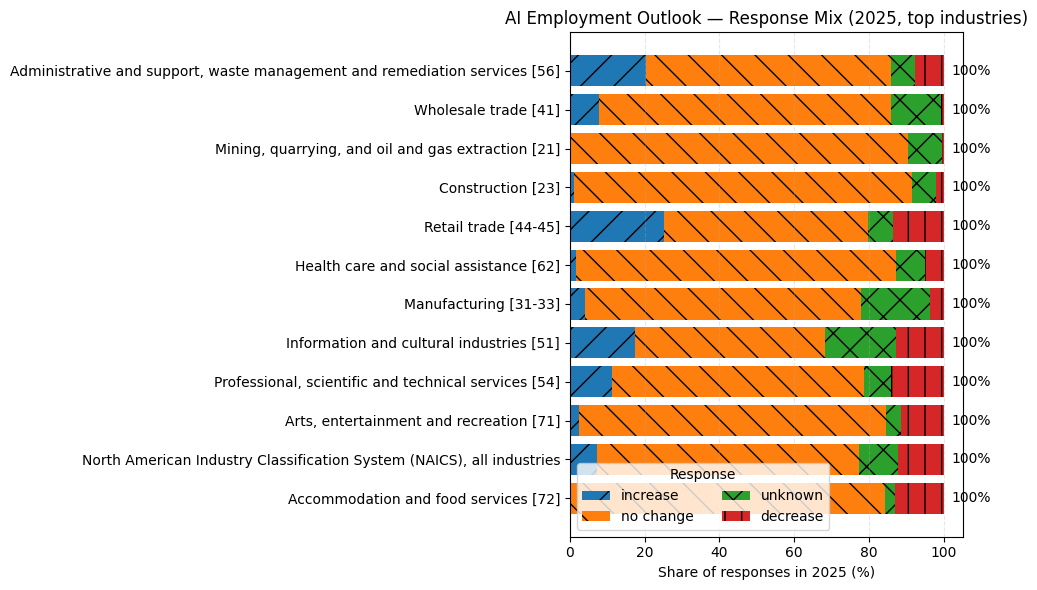

In [7]:
import os, numpy as np, matplotlib.pyplot as plt
os.makedirs("figures", exist_ok=True)

# Ensure p25 exists (2025 pivot with columns: increase, decrease, no change, unknown, Overall_Thoughts)
if "p25" not in globals():
    print("Re-run the loading cell to create p25/p24 pivots.")
else:
    # pick top industries by Overall_Thoughts
    topN = 12
    top_idx = p25["Overall_Thoughts"].sort_values(ascending=False).head(topN).index
    take = p25.loc[top_idx, ["increase","no change","unknown","decrease"]].fillna(0.0)

    # normalize rows to 100%
    row_sums = take.sum(axis=1).replace(0, np.nan)
    parts = (take.T / row_sums).T * 100

    fig, ax = plt.subplots(figsize=(10, 6))
    y = np.arange(len(parts))
    left = np.zeros(len(parts))

    labels = ["increase","no change","unknown","decrease"]
    hatches = ["/","\\","x","|"]

    for k, hatch in zip(labels, hatches):
        vals = parts[k].to_numpy(dtype=float)
        bars = ax.barh(y, vals, left=left, hatch=hatch, label=k)
        left += vals

    ax.set_yticks(y, parts.index)
    ax.invert_yaxis()
    ax.set_xlabel("Share of responses in 2025 (%)")
    ax.set_title("AI Employment Outlook — Response Mix (2025, top industries)")

    # annotate last segment with 100%
    for i in range(len(parts)):
        ax.text(102, i, "100%", va="center")
    ax.legend(title="Response", ncols=2)
    plt.grid(axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.savefig("figures/exp_2025_stacked_mix_top_industries.png", dpi=200, bbox_inches="tight")
    print("Saved: figures/exp_2025_stacked_mix_top_industries.png")
    plt.show()


Saved: figures/exp_dumbbell_top_movers.png


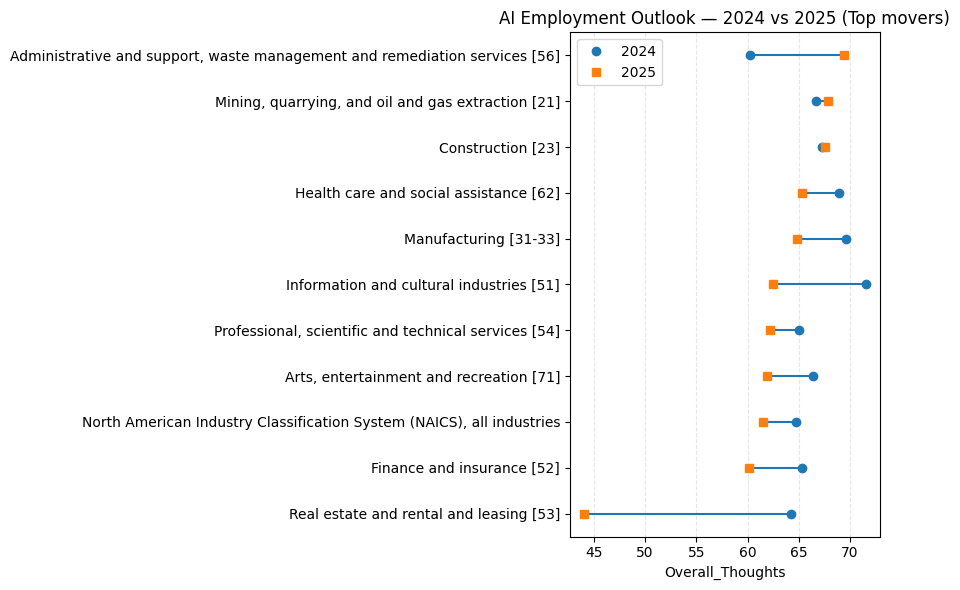

In [8]:
import numpy as np, matplotlib.pyplot as plt

df = ai_exp_naic.dropna(subset=["Overall_Thoughts_2024","Overall_Thoughts_2025"]).copy()
take = df.sort_values("Difference", ascending=False).head(15).sort_values("Overall_Thoughts_2025")

fig, ax = plt.subplots(figsize=(9, 6))
y = np.arange(len(take))

# lines
ax.hlines(y=y, xmin=take["Overall_Thoughts_2024"], xmax=take["Overall_Thoughts_2025"])
# endpoints
ax.plot(take["Overall_Thoughts_2024"], y, "o", label="2024")
ax.plot(take["Overall_Thoughts_2025"], y, "s", label="2025")

ax.set_yticks(y, take.index)
ax.set_xlabel("Overall_Thoughts")
ax.set_title("AI Employment Outlook — 2024 vs 2025 (Top movers)")
ax.legend()
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/exp_dumbbell_top_movers.png", dpi=200, bbox_inches="tight")
print("Saved: figures/exp_dumbbell_top_movers.png")
plt.show()


Saved: figures\exp_top_levels_2025.png


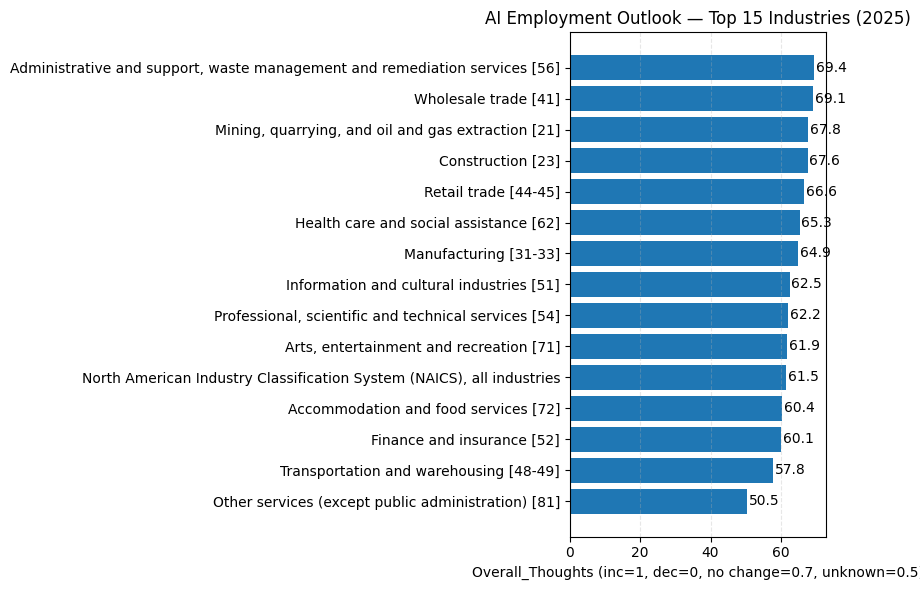

TypeError: boolean value of NA is ambiguous

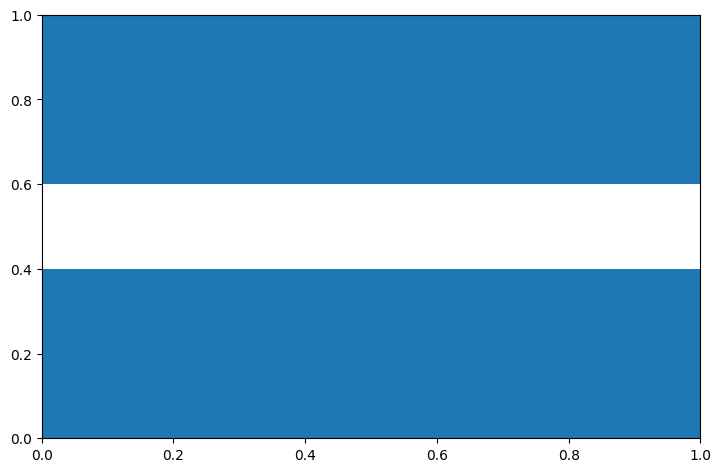

In [6]:
# === ONE-CELL FIX + CHARTS (apples-to-apples with Jo) ===
# 1) ensure matplotlib is installed in THIS kernel
import sys, subprocess
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "matplotlib"])
    import matplotlib.pyplot as plt

import os, re, numpy as np, pandas as pd
os.makedirs("figures", exist_ok=True)

def savefig(name):
    plt.tight_layout()
    p = os.path.join("figures", name)
    plt.savefig(p, dpi=200, bbox_inches="tight")
    print("Saved:", p)

# 2) load expectations tables exactly like Jo (33101047 for 2025, 33100880 for 2024)
def load_expectations(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, dtype="string", encoding="utf-8-sig")
    df = df.rename(columns={
        "Business's or organization's expectation of the impact of artificial intelligence on total employment": "Survey_Question"
    })
    df = df[["GEO","Business characteristics","Survey_Question","VALUE","STATUS"]].copy()
    df = df[(df["GEO"] == "Canada") & (df["STATUS"] != "F")].copy()  # Canada-only, drop 'F'
    bc = df["Business characteristics"].fillna("")
    naics_mask = bc.str.contains(r"\[", regex=True) | bc.str.contains("NAICS", case=False, regex=False)
    df = df[naics_mask].copy()  # keep NAICS industries (incl. all-industries line)
    df["VALUE"] = pd.to_numeric(df["VALUE"], errors="coerce")
    df["question"] = df["Survey_Question"].str.split(",").str[-1].str.strip().str.lower()
    return df

def pivot_overall(df: pd.DataFrame) -> pd.DataFrame:
    pv = df.pivot_table(index="Business characteristics", columns="question", values="VALUE", aggfunc="first")
    for k in ["increase","decrease","no change","unknown"]:
        if k not in pv.columns: pv[k] = np.nan
    pv = pv[["increase","decrease","no change","unknown"]]
    # Jo’s weights
    pv["Overall_Thoughts"] = (pv["increase"]*1.0) + (pv["decrease"]*0.0) + (pv["no change"]*0.7) + (pv["unknown"]*0.5)
    return pv

# Adjust paths if your folders differ:
exp25 = load_expectations("../../data/Org-Expectations-Survey-2025/33101047.csv")
exp24 = load_expectations("../../data/Org-Expectations-Survey-2024/33100880.csv")
p25 = pivot_overall(exp25)
p24 = pivot_overall(exp24)
ai_exp_naic = (
    p25[["Overall_Thoughts"]]
      .merge(p24[["Overall_Thoughts"]], left_index=True, right_index=True, suffixes=("_2025","_2024"))
)
ai_exp_naic["Difference"] = ai_exp_naic["Overall_Thoughts_2025"] - ai_exp_naic["Overall_Thoughts_2024"]

# 3) CHARTS
# (A) Top industries by 2025 level
ai_exp_naic_sorted25 = ai_exp_naic.sort_values("Overall_Thoughts_2025", ascending=False)
topN = 15
take = ai_exp_naic_sorted25.head(topN)
fig, ax = plt.subplots(figsize=(8.5, 6))
ax.barh(range(len(take)), take["Overall_Thoughts_2025"].values)
ax.set_yticks(range(len(take)), labels=take.index)
ax.invert_yaxis()
ax.set_title(f"AI Employment Outlook — Top {topN} Industries (2025)")
ax.set_xlabel("Overall_Thoughts (inc=1, dec=0, no change=0.7, unknown=0.5)")
for i, v in enumerate(take["Overall_Thoughts_2025"].values):
    ax.text(v + 0.5, i, f"{v:.1f}", va="center")
plt.grid(axis="x", linestyle="--", alpha=0.3)
savefig("exp_top_levels_2025.png")
plt.show()

# (B) Biggest improvements (2025 − 2024)
ai_exp_naic_sortedDiff = ai_exp_naic.sort_values("Difference", ascending=False)
topN = 12
pos = ai_exp_naic_sortedDiff.head(topN)
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.barh(range(len(pos)), pos["Difference"].values)
ax.set_yticks(range(len(pos)), labels=pos.index)
ax.invert_yaxis()
ax.set_title("AI Employment Outlook — Largest Increases (2025 − 2024)")
ax.set_xlabel("Difference in Overall_Thoughts")
for i, v in enumerate(pos["Difference"].values):
    ax.text(v + 0.3, i, f"{v:+.1f}", va="center")
plt.axvline(0, linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.3)
savefig("exp_top_gainers_diff.png")
plt.show()

# (C) Biggest declines (2025 − 2024)
topN = 12
neg = ai_exp_naic_sortedDiff.tail(topN).sort_values("Difference", ascending=True)
fig, ax = plt.subplots(figsize=(8.5, 5.5))
ax.barh(range(len(neg)), neg["Difference"].values)
ax.set_yticks(range(len(neg)), labels=neg.index)
ax.invert_yaxis()
ax.set_title("AI Employment Outlook — Largest Declines (2025 − 2024)")
ax.set_xlabel("Difference in Overall_Thoughts")
for i, v in enumerate(neg["Difference"].values):
    ax.text(v - 0.5, i, f"{v:+.1f}", va="center", ha="right")
plt.axvline(0, linewidth=1)
plt.grid(axis="x", linestyle="--", alpha=0.3)
savefig("exp_top_decliners_diff.png")
plt.show()

# (D) 2025 vs 2024 scatter with 45° line
fig, ax = plt.subplots(figsize=(6.8, 6.2))
x = ai_exp_naic["Overall_Thoughts_2024"].values
y = ai_exp_naic["Overall_Thoughts_2025"].values
ax.scatter(x, y)
lims = [min(np.nanmin(x), np.nanmin(y)) - 2, max(np.nanmax(x), np.nanmax(y)) + 2]
ax.plot(lims, lims)
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_xlabel("Overall_Thoughts 2024")
ax.set_ylabel("Overall_Thoughts 2025")
ax.set_title("AI Employment Outlook — 2025 vs 2024 (Industry)")
# label movers (top/bottom 8 by Difference)
movers = ai_exp_naic.reindex(ai_exp_naic_sortedDiff.head(8).index.union(ai_exp_naic_sortedDiff.tail(8).index))
for idx, row in movers.iterrows():
    ax.annotate(idx, (row["Overall_Thoughts_2024"], row["Overall_Thoughts_2025"]),
                xytext=(5,5), textcoords="offset points", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.3)
savefig("exp_scatter_2025_vs_2024.png")
plt.show()
